In [1]:
from nanopelican.models import load_experiment
import matplotlib.pyplot as plt


In [2]:
model, history = load_experiment('experiments/zenodo-0')

In [3]:
print(model.__dict__)

{'_tracker': <keras.src.utils.tracking.Tracker object at 0x000002843AE21090>, '_self_setattr_tracking': True, '_trainable_variables': [], '_non_trainable_variables': [], '_layers': [<DataHandler name=data_handler, built=True>, <Lineq2v2nano name=lineq2v2nano, built=True>, <Lineq2v0nano name=lineq2v0nano, built=True>], '_metrics': [], '_seed_generators': [], '_lock': False, '_auto_config': <keras.src.saving.serialization_lib.SerializableDict object at 0x000002843AE291D0>, 'build': <function PelicanNano.build at 0x000002843B409760>, '_run_eagerly': False, '_jit_compile': False, 'compiled': True, 'loss': <keras.src.losses.losses.CategoricalCrossentropy object at 0x000002843B3E0D90>, 'steps_per_execution': 1, '_initial_epoch': None, 'train_function': None, 'test_function': None, 'predict_function': None, '_distribute_strategy': None, '_distribute_reduction_method': None, '_supports_reduce_retracing': True, '_saved_model_inputs_spec': None, '_saved_model_arg_spec': None, '_tracked': ['_inbo

In [4]:
for key in history:
    print(key)

loss = history['loss']
acc = history['acc']
val_loss = history['val_loss']
val_acc = history['val_acc']
args = history['args']

acc
loss
val_acc
val_loss
args


In [5]:
for key, val in args.__dict__.items():
    print(key, val)

data_dir zenodo_data/raw
feature_key jetConstituentList
label_key jets
evaluate_models None
n_hidden 1
n_outputs 5
activation relu
dropout_rate 0.0
use_batchnorm True
data_format inverted
load True
num_particles 32
print_summary True
num_particles_avg 49
batch_size 512
epochs 10
validation_size 1000
experiment_root experiments
experiment_name zenodo
data_interpreter zenodo


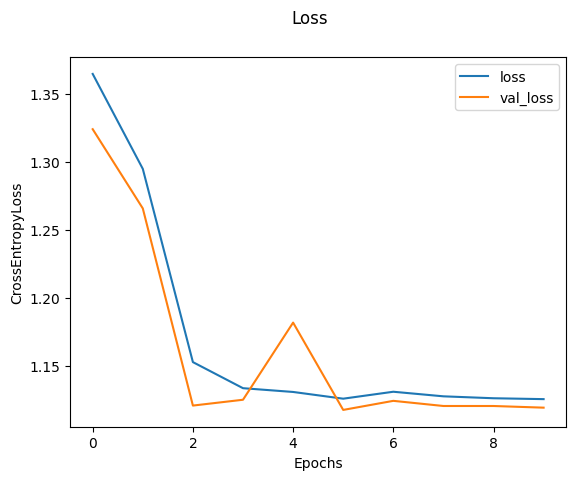

In [6]:
fig, ax = plt.subplots()
ax.plot(loss, label='loss')
ax.plot(val_loss, label='val_loss')
ax.set_ylabel("CrossEntropyLoss")
ax.set_xlabel("Epochs")
fig.suptitle("Loss")
plt.legend()

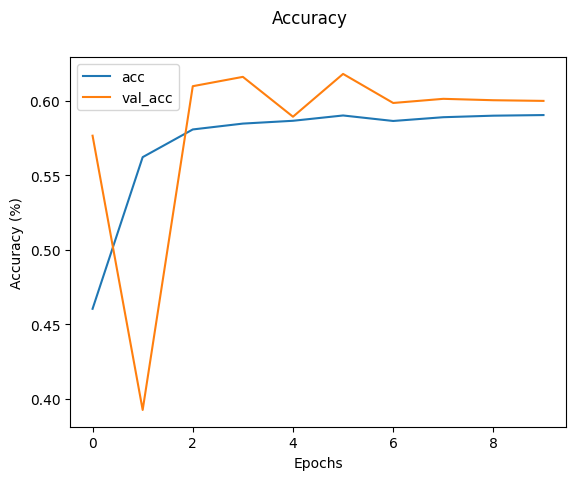

In [7]:
fig, ax = plt.subplots()
ax.plot(acc, label='acc')
ax.plot(val_acc, label='val_acc')
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Epochs")
fig.suptitle("Accuracy")
plt.legend()

In [8]:

optimizer = model.optimizer
conf = optimizer.get_config()['learning_rate']#['config']

In [9]:
import tensorflow as tf
scheduler = optimizer._learning_rate
steps = tf.range(scheduler.epochs*scheduler.steps_per_epoch, dtype=tf.float32, delta=scheduler.steps_per_epoch//10)
learning_rate = tf.map_fn(scheduler, steps)


Text(0.5, 0.98, 'LR schedule')

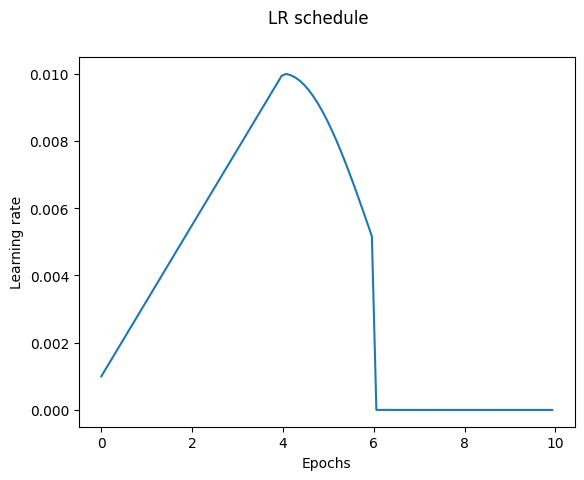

In [10]:
plt.plot(steps / scheduler.steps_per_epoch, learning_rate)
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.suptitle("LR schedule")

In [11]:
import numpy as np
w = model.get_weights()
w = np.concatenate([elem.flatten() for elem in w])
print(w)


[-1.8589404e+00 -1.1078607e-01  6.0511100e-01  5.8181912e-01
 -4.8370633e+00  3.7856180e-02  3.2310300e+00  6.7229283e-01
  4.8743007e-01  6.5100812e-03  7.9035726e+00  1.1115710e+03
  1.2296444e+00  1.5780267e+00 -1.9336238e+00 -2.2871802e+00
  7.8751969e-01 -7.0972323e-01 -7.3303473e-01  1.5722132e+00
  1.1083132e+00 -1.0889093e+00  1.4842938e+00  9.8800868e-01
 -1.8361284e+00 -1.5027801e+00  1.3978703e+00  4.0618825e+00
  2.8626183e-01  4.1528134e+00  1.8761570e+01]


[ 7.0407259e-01  1.1045378e-01 -1.1407734e+01 -1.1421990e+01
 -7.0211571e-01 -1.2425658e+00  9.6760464e-01  9.9075603e+00
  2.1996875e+00 -1.4852539e-01  1.7246685e+01  4.6822183e+03
 -2.1967337e+00 -7.7857471e-01  8.1014943e-01  1.8107696e+00
 -9.6010029e-01  3.2078568e+01  6.1694619e+03]